1.Loading necessary libraries

In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


#for building and training the U-Net model
from tensorflow.keras.layers import Conv2D, Input, Concatenate, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model

print("Loaded all libraries")

Loaded all libraries


In [2]:
!pip install SimpleITK

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 12.2 MB/s eta 0:00:00


2.Converting NIFTI to tiff files

In [3]:
import os
import SimpleITK as sitk

input_directory = '/content/drive/MyDrive/biocliq/imagesTr'
output_directory = '/content/drive/MyDrive/biocliq/img'

for file in os.listdir(input_directory):
    if file.endswith('.nii.gz'):
        input_path = os.path.join(input_directory, file)
        img = sitk.ReadImage(input_path)
        output_path = os.path.join(output_directory, file.replace('.nii.gz', '.tif'))
        sitk.WriteImage(img, output_path)


In [4]:
import os
import SimpleITK as sitk

input_directory = '/content/drive/MyDrive/biocliq/labelsTr'
output_directory = '/content/drive/MyDrive/biocliq/msk'

for file in os.listdir(input_directory):
    if file.endswith('.nii.gz'):
        input_path = os.path.join(input_directory, file)
        img = sitk.ReadImage(input_path)
        output_path = os.path.join(output_directory, file.replace('.nii.gz', '.tif'))
        sitk.WriteImage(img, output_path)


In [11]:
# Reshape y_combined to match the shape of X
y_combined = y_combined.reshape((y_combined.shape[0], y_combined.shape[1], y_combined.shape[2], 1))




In [14]:
# prompt: make the shape of y_combined (45,128,128,1)

y_combined = y_combined.reshape((y_combined.shape[0], y_combined.shape[1], y_combined.shape[2], 1))


In [15]:
print("Shape of X:", X.shape)
print("Shape of y_combined:", y_combined.shape)

Shape of X: (45, 128, 128, 1)
Shape of y_combined: (128, 128, 1, 1)


In [53]:
print("No. of images =",len(os.listdir(train_fpath)))
print("No. of image masks =",len(os.listdir(train_masks_fpath)))

No. of images = 45
No. of image masks = 45


In [17]:
train_fpath='/content/drive/MyDrive/biocliq/img'
train_masks_fpath='/content/drive/MyDrive/biocliq/msk'

#test_fpath='../input/3d_images/'
#test_masks_fpath='../input/3d_masks/'
print(os.listdir('/content/drive/MyDrive/biocliq/img'))

['1.3.6.1.4.1.14519.5.2.1.6279.6001.188376349804761988217597754952_0000.tif', '1.3.6.1.4.1.14519.5.2.1.6279.6001.249530219848512542668813996730_0000.tif', '1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059_0000.tif', '1.3.6.1.4.1.14519.5.2.1.6279.6001.139713436241461669335487719526_0000.tif', '1.3.6.1.4.1.14519.5.2.1.6279.6001.146429221666426688999739595820_0000.tif', '1.3.6.1.4.1.14519.5.2.1.6279.6001.219087313261026510628926082729_0000.tif', '1.3.6.1.4.1.14519.5.2.1.6279.6001.227962600322799211676960828223_0000.tif', '1.3.6.1.4.1.14519.5.2.1.6279.6001.134996872583497382954024478441_0000.tif', '1.3.6.1.4.1.14519.5.2.1.6279.6001.122763913896761494371822656720_0000.tif', '1.3.6.1.4.1.14519.5.2.1.6279.6001.302134342469412607966016057827_0000.tif', '1.3.6.1.4.1.14519.5.2.1.6279.6001.241570579760883349458693655367_0000.tif', '1.3.6.1.4.1.14519.5.2.1.6279.6001.281489753704424911132261151767_0000.tif', '1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674661221381920536987_0000.tif'

3.Initialize Image Data and execute segmentation as instructed

In [25]:
def initialize_img_data(folder, left_lung_mask_folder, right_lung_mask_folder):
    lst = []
    for image_file in os.listdir(folder):
        # Load image in grayscale
        img = cv2.imread(os.path.join(folder, image_file), cv2.IMREAD_GRAYSCALE)
        # Convert to array
        img_array = Image.fromarray(img)
        # Resize image
        resize_img = img_array.resize((128, 128))
        # Divide by 255 -> scaling data
        norm_img = np.array(resize_img) / 255
        # Expand dimensions
        img_array = norm_img.reshape((128, 128, 1))  # np.expand_dims(norm_img, axis=3)

        resize_mask = None

        # Load left and right lung masks
        left_lung_mask = cv2.imread(os.path.join(left_lung_mask_folder, image_file), cv2.IMREAD_GRAYSCALE)
        right_lung_mask = cv2.imread(os.path.join(right_lung_mask_folder, image_file), cv2.IMREAD_GRAYSCALE)

        # Combine left and right lung masks into a single label (1 for lungs, 0 for background)
        if left_lung_mask is None or right_lung_mask is None:
            lung_mask_combined = left_lung_mask if left_lung_mask is not None else right_lung_mask
        else:
            lung_mask_combined = np.maximum(left_lung_mask, right_lung_mask)


        # Eliminate trachea label (set trachea pixels to 0)
        if lung_mask_combined is not None:
            lung_mask_combined[lung_mask_combined == 5] = 0

        # Resize the lung mask to match the image size
        if lung_mask_combined is not None:
            resize_mask = Image.fromarray(lung_mask_combined).resize((128, 128))
        # Convert to array
        # Convert to array if resize_mask is not None
        norm_mask = np.array(resize_mask) / 255 if resize_mask is not None else None
        # Expand dimensions if norm_mask is not None
        lung_mask_combined_array = norm_mask.reshape((128, 128, 1)) if norm_mask is not None else None

        lst.append((img_array, lung_mask_combined_array))

    return lst

# Specify the paths for image, left lung mask, and right lung mask folders
train_fpath = '/content/drive/MyDrive/biocliq/img'
left_lung_mask_fpath = '/path/to/left/lung/masks'
right_lung_mask_fpath = '/path/to/right/lung/masks'

data = initialize_img_data(train_fpath, left_lung_mask_fpath, right_lung_mask_fpath)


In [26]:
print(len(os.listdir(train_fpath)),len(X),len(y))
print(X[0].shape,y[0].shape)

45 45 45
(128, 128, 1) (128, 128, 1)


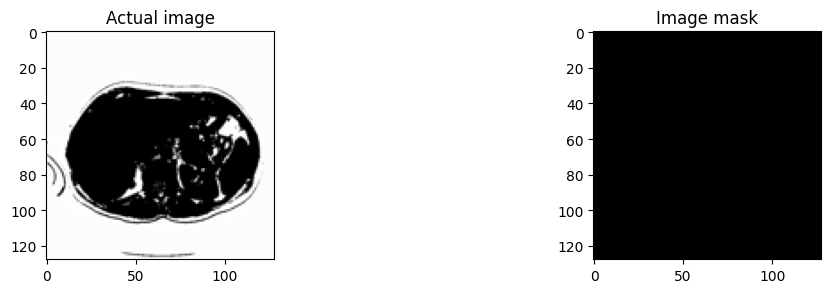

In [27]:
#check data once they are loaded
plt.figure(figsize=(10,10))
plt.subplot(1,3,1,title='Actual image')
plt.imshow(X[10],cmap="gray")

plt.subplot(1,3,3,title='Image mask')
plt.imshow(y[10],cmap="gray")

In [30]:
X = np.array(X)
y = np.array(y)

4.Split data into training,testing and validation sets

In [34]:
# Manually split the data into training, validation, and test sets
total_samples = len(X)
train_samples = 20
val_samples = (total_samples - train_samples) // 2
test_samples = total_samples - train_samples - val_samples

x_train, y_train = X[:train_samples], y_combined[:train_samples]
x_val, y_val = X[train_samples:train_samples + val_samples], y_combined[train_samples:train_samples + val_samples]
x_test, y_test = X[train_samples + val_samples:train_samples + val_samples + test_samples], y_combined[train_samples + val_samples:train_samples + val_samples + test_samples]

# Check the shapes of your data arrays
print("Shape of x_train:", x_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of x_val:", x_val.shape)
print("Shape of y_val:", y_val.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_test:", y_test.shape)


Shape of x_train: (20, 128, 128, 1)
Shape of y_train: (20, 128, 1)
Shape of x_val: (12, 128, 128, 1)
Shape of y_val: (12, 128, 1)
Shape of x_test: (13, 128, 128, 1)
Shape of y_test: (13, 128, 1)


5.Define UNET model

In [35]:
# Build U-Net model - Define layers
inputs = Input(shape=(128, 128, 1))

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (inputs)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = Concatenate()([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = Concatenate()([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = Concatenate()([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = Concatenate()([u9, c1]) #removed ,axis=3
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

In [36]:
model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 8)          80        ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 8)          584       ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 8)            0         ['conv2d_1[0][0]']            
 D)                                                                                           

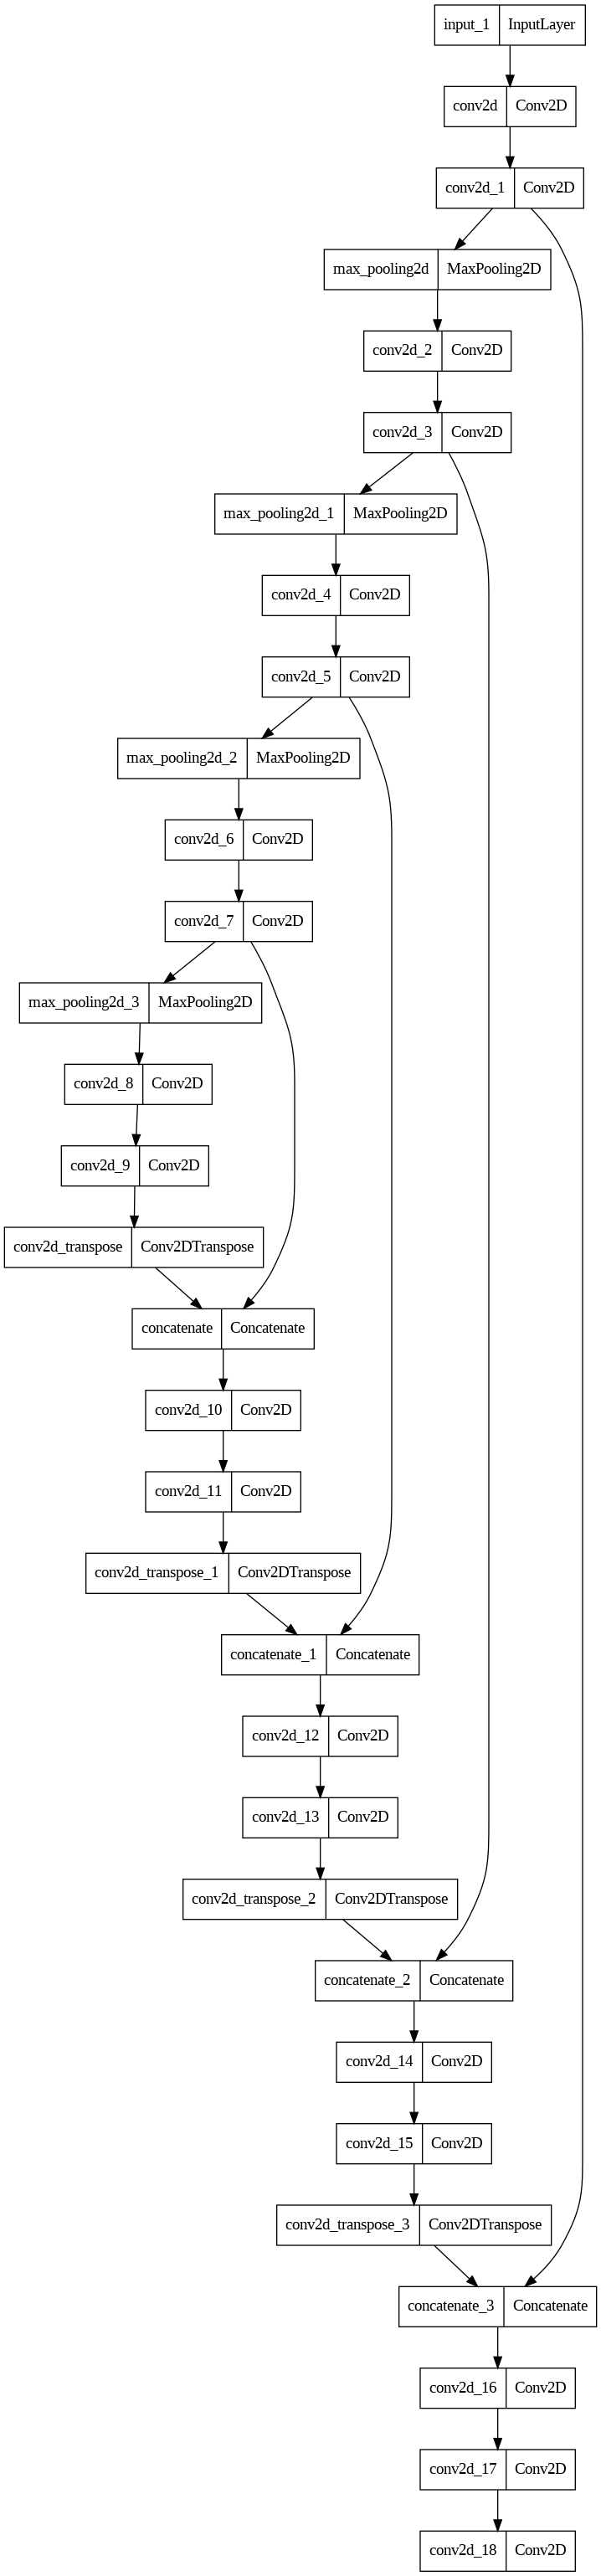

In [37]:
from keras.utils import plot_model
plot_model(model,to_file='model.png')

In [38]:
x_train.shape

(20, 128, 128, 1)

6.EVALUATE

In [39]:
early_stop = EarlyStopping(patience=5)
check_point = ModelCheckpoint('model.hdf5',save_best_only=True)
model.fit(x_train, y_train, epochs=200, callbacks=[early_stop,check_point])

Epoch 1/200
1/1 [==============================] - ETA: 0s - loss: 0.7875

1/1 [==============================] - 8s 8s/step - loss: 0.7875
Epoch 2/200
1/1 [==============================] - ETA: 0s - loss: 0.7616

1/1 [==============================] - 1s 1s/step - loss: 0.7616
Epoch 3/200
1/1 [==============================] - ETA: 0s - loss: 0.7399

1/1 [==============================] - 1s 1s/step - loss: 0.7399
Epoch 4/200
1/1 [==============================] - ETA: 0s - loss: 0.7237

1/1 [==============================] - 1s 1s/step - loss: 0.7237
Epoch 5/200
1/1 [==============================] - ETA: 0s - loss: 0.7147

1/1 [==============================] - 1s 1s/step - loss: 0.7147
Epoch 6/200
1/1 [==============================] - ETA: 0s - loss: 0.7057

1/1 [==============================] - 1s 993ms/step - loss: 0.7057
Epoch 7/200
1/1 [==============================] - ETA: 0s - loss: 0.6969

1/1 [==============================] - 1s 992ms/step - loss: 0.6969
Epoch 8/200
1/1 [==============================] - ETA: 0s - loss: 0.6886

1/1 [==============================] - 1s 1s/step - loss: 0.6886
Epoch 9/200
1/1 [==============================] - ETA: 0s - loss: 0.6813

1/1 [==============================] - 1s 1s/step - loss: 0.6813
Epoch 10/200
1/1 [==============================] - ETA: 0s - loss: 0.6743

1/1 [==============================] - 1s 1s/step - loss: 0.6743
Epoch 11/200
1/1 [==============================] - ETA: 0s - loss: 0.6659

1/1 [==============================] - 1s 1s/step - loss: 0.6659
Epoch 12/200
1/1 [==============================] - ETA: 0s - loss: 0.6515

1/1 [==============================] - 2s 2s/step - loss: 0.6515
Epoch 13/200
1/1 [==============================] - ETA: 0s - loss: 0.6211

1/1 [==============================] - 2s 2s/step - loss: 0.6211
Epoch 14/200
1/1 [==============================] - ETA: 0s - loss: 0.5479

1/1 [==============================] - 2s 2s/step - loss: 0.5479
Epoch 15/200
1/1 [==============================] - ETA: 0s - loss: 0.3750

1/1 [==============================] - 1s 1s/step - loss: 0.3750
Epoch 16/200
1/1 [==============================] - ETA: 0s - loss: 0.1255

1/1 [==============================] - 1s 983ms/step - loss: 0.1255
Epoch 17/200
1/1 [==============================] - ETA: 0s - loss: 0.0232

1/1 [==============================] - 1s 1s/step - loss: 0.0232
Epoch 18/200
1/1 [==============================] - ETA: 0s - loss: 0.0079

1/1 [==============================] - 1s 978ms/step - loss: 0.0079
Epoch 19/200
1/1 [==============================] - ETA: 0s - loss: 0.0027

1/1 [==============================] - 1s 1s/step - loss: 0.0027
Epoch 20/200
1/1 [==============================] - ETA: 0s - loss: 9.7475e-04

1/1 [==============================] - 1s 1s/step - loss: 9.7475e-04
Epoch 21/200
1/1 [==============================] - ETA: 0s - loss: 0.0012

1/1 [==============================] - 1s 1s/step - loss: 0.0012
Epoch 22/200
1/1 [==============================] - ETA: 0s - loss: 0.0012

1/1 [==============================] - 1s 987ms/step - loss: 0.0012
Epoch 23/200
1/1 [==============================] - ETA: 0s - loss: 9.6137e-04

1/1 [==============================] - 1s 981ms/step - loss: 9.6137e-04
Epoch 24/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 25/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 2s 2s/step - loss: 9.3074e-04
Epoch 26/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 2s 2s/step - loss: 9.3074e-04
Epoch 27/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 2s 2s/step - loss: 9.3074e-04
Epoch 28/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 29/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 998ms/step - loss: 9.3074e-04
Epoch 30/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 981ms/step - loss: 9.3074e-04
Epoch 31/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 32/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 980ms/step - loss: 9.3074e-04
Epoch 33/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 995ms/step - loss: 9.3074e-04
Epoch 34/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 995ms/step - loss: 9.3074e-04
Epoch 35/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 998ms/step - loss: 9.3074e-04
Epoch 36/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 992ms/step - loss: 9.3074e-04
Epoch 37/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 995ms/step - loss: 9.3074e-04
Epoch 38/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 39/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 2s 2s/step - loss: 9.3074e-04
Epoch 40/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 2s 2s/step - loss: 9.3074e-04
Epoch 41/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 2s 2s/step - loss: 9.3074e-04
Epoch 42/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 43/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 988ms/step - loss: 9.3074e-04
Epoch 44/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 985ms/step - loss: 9.3074e-04
Epoch 45/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 980ms/step - loss: 9.3074e-04
Epoch 46/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 47/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 48/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 983ms/step - loss: 9.3074e-04
Epoch 49/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 987ms/step - loss: 9.3074e-04
Epoch 50/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 968ms/step - loss: 9.3074e-04
Epoch 51/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 987ms/step - loss: 9.3074e-04
Epoch 52/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 53/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 2s 2s/step - loss: 9.3074e-04
Epoch 54/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 2s 2s/step - loss: 9.3074e-04
Epoch 55/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 2s 2s/step - loss: 9.3074e-04
Epoch 56/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 57/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 995ms/step - loss: 9.3074e-04
Epoch 58/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 982ms/step - loss: 9.3074e-04
Epoch 59/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 995ms/step - loss: 9.3074e-04
Epoch 60/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 991ms/step - loss: 9.3074e-04
Epoch 61/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 986ms/step - loss: 9.3074e-04
Epoch 62/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 992ms/step - loss: 9.3074e-04
Epoch 63/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 980ms/step - loss: 9.3074e-04
Epoch 64/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 992ms/step - loss: 9.3074e-04
Epoch 65/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 988ms/step - loss: 9.3074e-04
Epoch 66/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 2s 2s/step - loss: 9.3074e-04
Epoch 67/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 3s 3s/step - loss: 9.3074e-04
Epoch 68/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 2s 2s/step - loss: 9.3074e-04
Epoch 69/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 70/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 983ms/step - loss: 9.3074e-04
Epoch 71/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 988ms/step - loss: 9.3074e-04
Epoch 72/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 994ms/step - loss: 9.3074e-04
Epoch 73/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 980ms/step - loss: 9.3074e-04
Epoch 74/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 981ms/step - loss: 9.3074e-04
Epoch 75/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 987ms/step - loss: 9.3074e-04
Epoch 76/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 959ms/step - loss: 9.3074e-04
Epoch 77/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 993ms/step - loss: 9.3074e-04
Epoch 78/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 79/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 80/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 2s 2s/step - loss: 9.3074e-04
Epoch 81/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 2s 2s/step - loss: 9.3074e-04
Epoch 82/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 2s 2s/step - loss: 9.3074e-04
Epoch 83/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 993ms/step - loss: 9.3074e-04
Epoch 84/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1000ms/step - loss: 9.3074e-04
Epoch 85/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 973ms/step - loss: 9.3074e-04
Epoch 86/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 976ms/step - loss: 9.3074e-04
Epoch 87/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 988ms/step - loss: 9.3074e-04
Epoch 88/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1000ms/step - loss: 9.3074e-04
Epoch 89/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 997ms/step - loss: 9.3074e-04
Epoch 90/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 998ms/step - loss: 9.3074e-04
Epoch 91/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 92/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 93/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 2s 2s/step - loss: 9.3074e-04
Epoch 94/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 2s 2s/step - loss: 9.3074e-04
Epoch 95/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 2s 2s/step - loss: 9.3074e-04
Epoch 96/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 97/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 998ms/step - loss: 9.3074e-04
Epoch 98/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 982ms/step - loss: 9.3074e-04
Epoch 99/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 992ms/step - loss: 9.3074e-04
Epoch 100/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 101/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 2s 2s/step - loss: 9.3074e-04
Epoch 102/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 2s 2s/step - loss: 9.3074e-04
Epoch 103/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 2s 2s/step - loss: 9.3074e-04
Epoch 104/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 2s 2s/step - loss: 9.3074e-04
Epoch 105/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 2s 2s/step - loss: 9.3074e-04
Epoch 106/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 2s 2s/step - loss: 9.3074e-04
Epoch 107/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 2s 2s/step - loss: 9.3074e-04
Epoch 108/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 109/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 110/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 111/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 998ms/step - loss: 9.3074e-04
Epoch 112/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 991ms/step - loss: 9.3074e-04
Epoch 113/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 114/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 115/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 116/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 117/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 118/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 119/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 2s 2s/step - loss: 9.3074e-04
Epoch 120/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 2s 2s/step - loss: 9.3074e-04
Epoch 121/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 2s 2s/step - loss: 9.3074e-04
Epoch 122/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 123/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 124/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 125/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 126/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 127/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 998ms/step - loss: 9.3074e-04
Epoch 128/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 129/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 130/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 131/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 132/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 2s 2s/step - loss: 9.3074e-04
Epoch 133/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 2s 2s/step - loss: 9.3074e-04
Epoch 134/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 2s 2s/step - loss: 9.3074e-04
Epoch 135/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 136/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 137/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 2s 2s/step - loss: 9.3074e-04
Epoch 138/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 2s 2s/step - loss: 9.3074e-04
Epoch 139/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 140/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 141/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 142/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 143/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 2s 2s/step - loss: 9.3074e-04
Epoch 144/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 2s 2s/step - loss: 9.3074e-04
Epoch 145/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 2s 2s/step - loss: 9.3074e-04
Epoch 146/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 147/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 148/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 994ms/step - loss: 9.3074e-04
Epoch 149/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 150/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 151/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 152/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 153/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 154/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 155/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 2s 2s/step - loss: 9.3074e-04
Epoch 156/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 3s 3s/step - loss: 9.3074e-04
Epoch 157/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 2s 2s/step - loss: 9.3074e-04
Epoch 158/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 159/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 999ms/step - loss: 9.3074e-04
Epoch 160/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 999ms/step - loss: 9.3074e-04
Epoch 161/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 162/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 997ms/step - loss: 9.3074e-04
Epoch 163/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 164/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 165/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 166/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 167/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 991ms/step - loss: 9.3074e-04
Epoch 168/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 2s 2s/step - loss: 9.3074e-04
Epoch 169/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 2s 2s/step - loss: 9.3074e-04
Epoch 170/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 2s 2s/step - loss: 9.3074e-04
Epoch 171/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 172/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 173/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 174/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 175/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 176/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 177/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 993ms/step - loss: 9.3074e-04
Epoch 178/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 179/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 180/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 181/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 182/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 2s 2s/step - loss: 9.3074e-04
Epoch 183/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 2s 2s/step - loss: 9.3074e-04
Epoch 184/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 2s 2s/step - loss: 9.3074e-04
Epoch 185/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 186/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 187/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 188/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 189/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 190/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 191/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 192/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 193/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 194/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 195/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 2s 2s/step - loss: 9.3074e-04
Epoch 196/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 2s 2s/step - loss: 9.3074e-04
Epoch 197/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 2s 2s/step - loss: 9.3074e-04
Epoch 198/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04
Epoch 199/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 999ms/step - loss: 9.3074e-04
Epoch 200/200
1/1 [==============================] - ETA: 0s - loss: 9.3074e-04

1/1 [==============================] - 1s 1s/step - loss: 9.3074e-04


7.DICE SCORE

In [47]:
# Assuming your model is already trained and stored in the 'model' variable
# You should load your model using model.load_weights('model.hdf5') if it's not already loaded

# Predict on the test set
y_pred = model.predict(x_test)

# Reshape y_pred to match the shape of y_test
y_pred = y_pred.squeeze(axis=-1)  # Remove the singleton channel dimension

# Define the Dice coefficient function
def dice_coef(y_true, y_pred, smooth=1):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred)
    return (2.0 * intersection + smooth) / (union + smooth)

# Evaluate the Dice score on the test set
dice_score = dice_coef(y_test, y_pred)
print(f"Dice Score on Test Set: {dice_score}")


1/1 [==============================] - 0s 193ms/step
Dice Score on Test Set: 0.07142857142857142


8. SAVED MODEL

In [52]:
model.save('lung_model_1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
